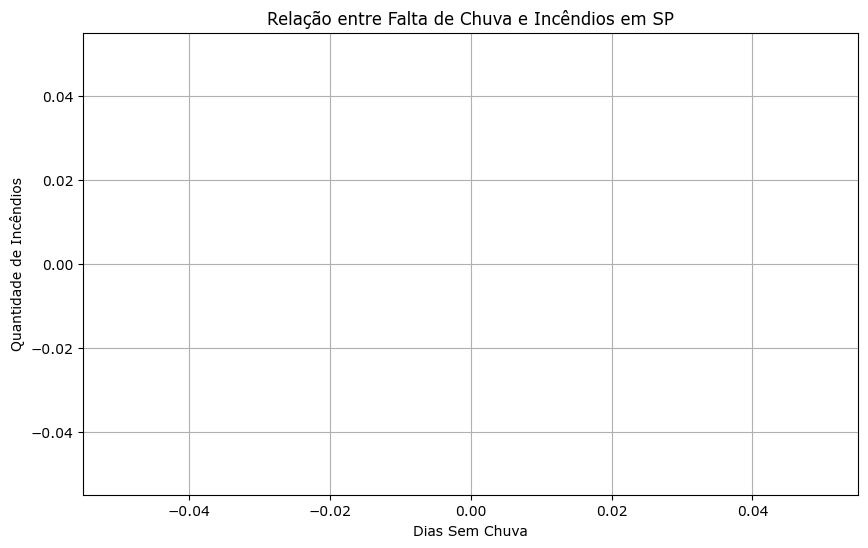

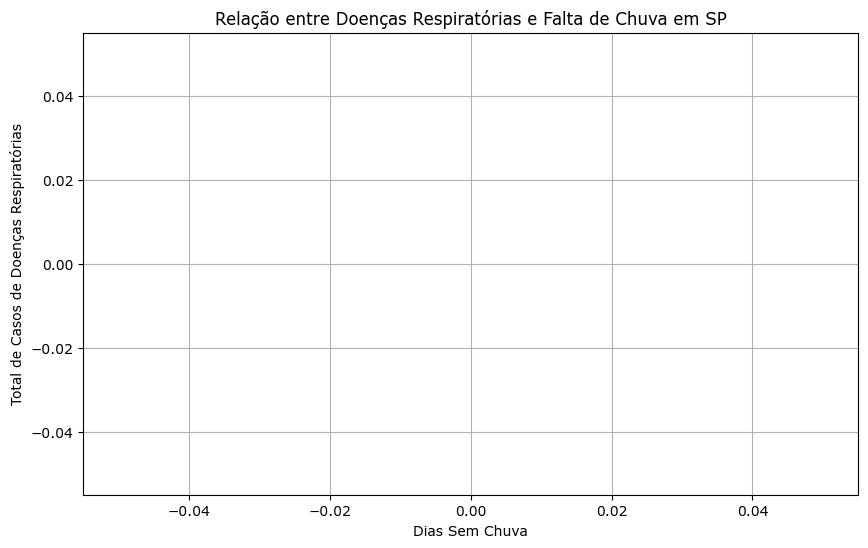

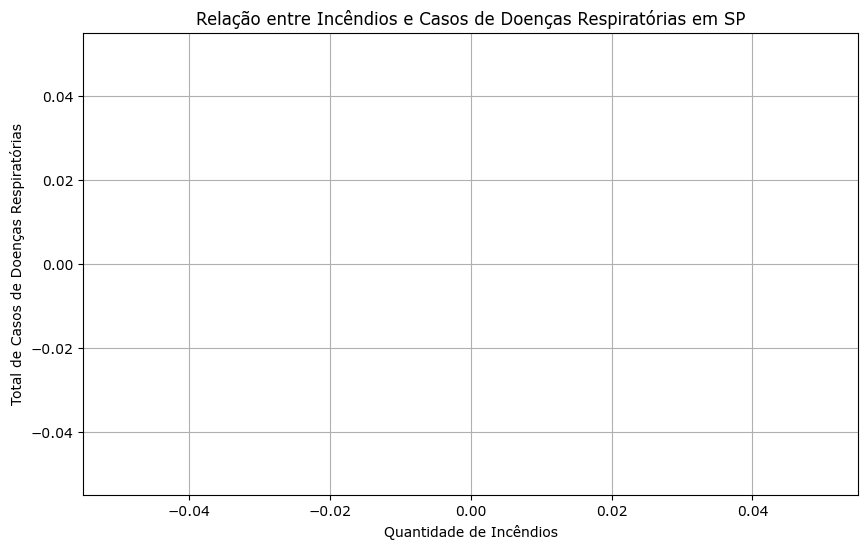

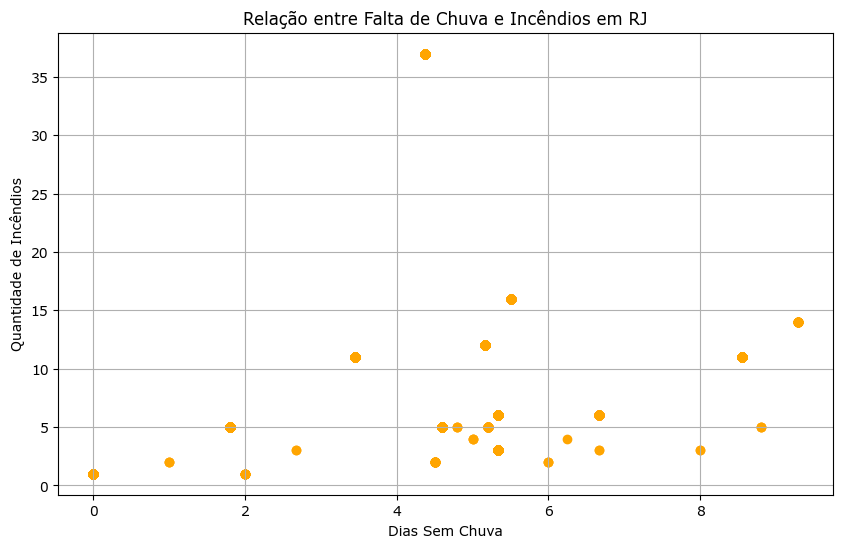

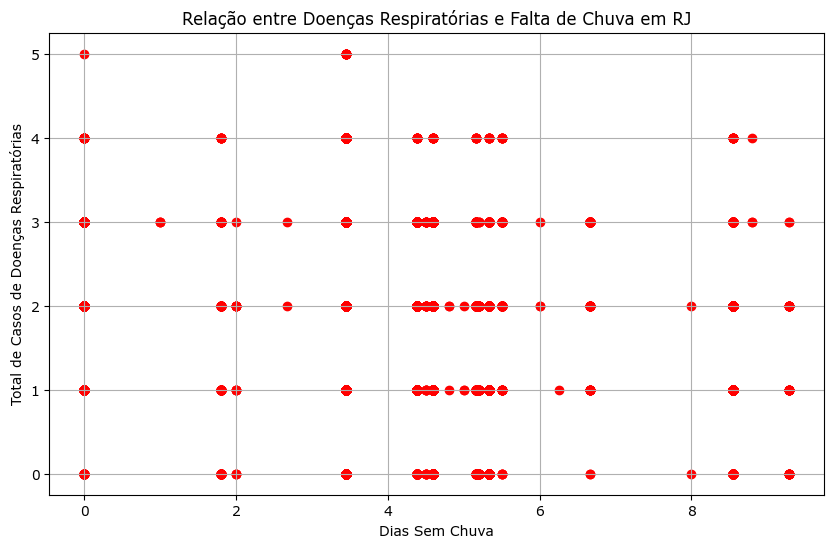

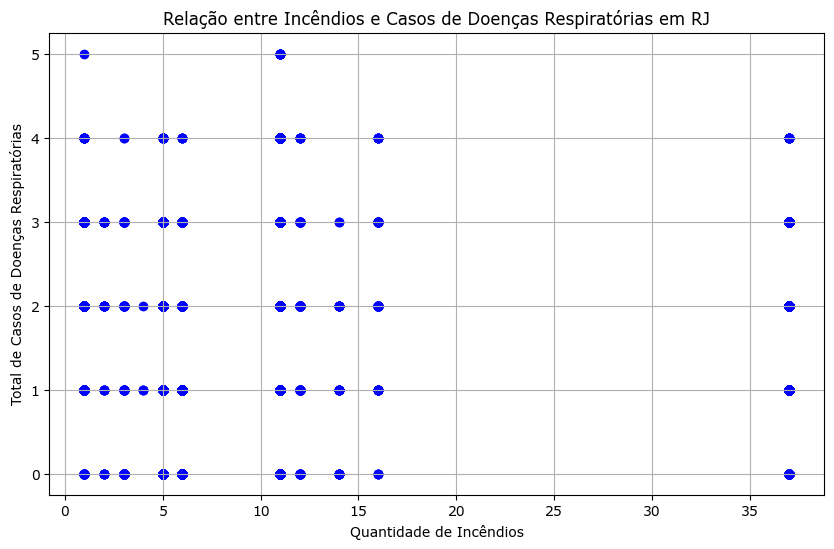

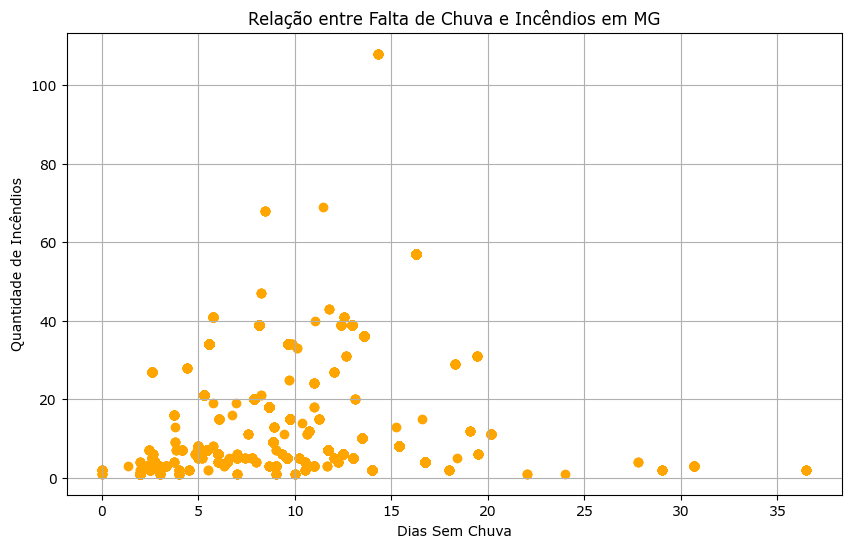

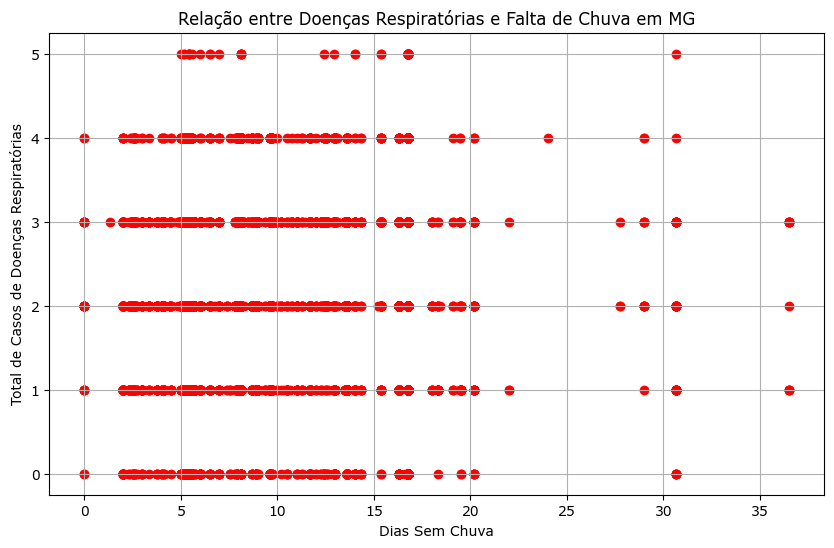

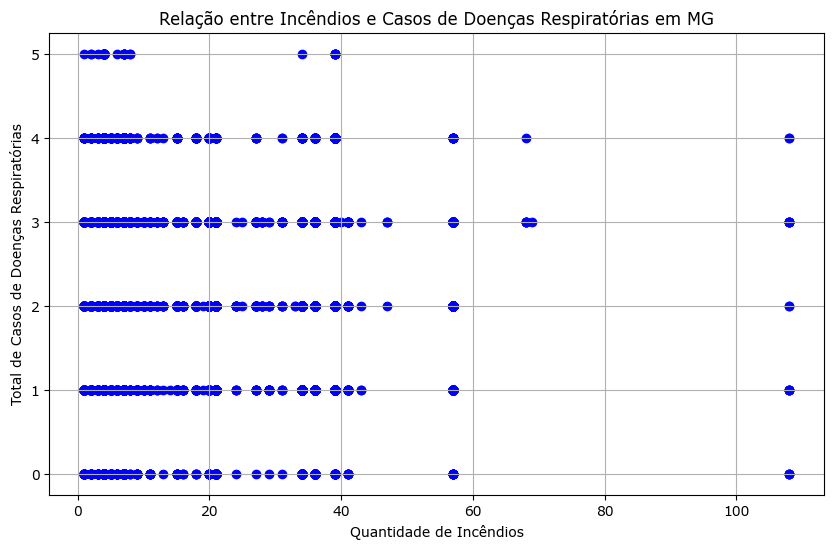

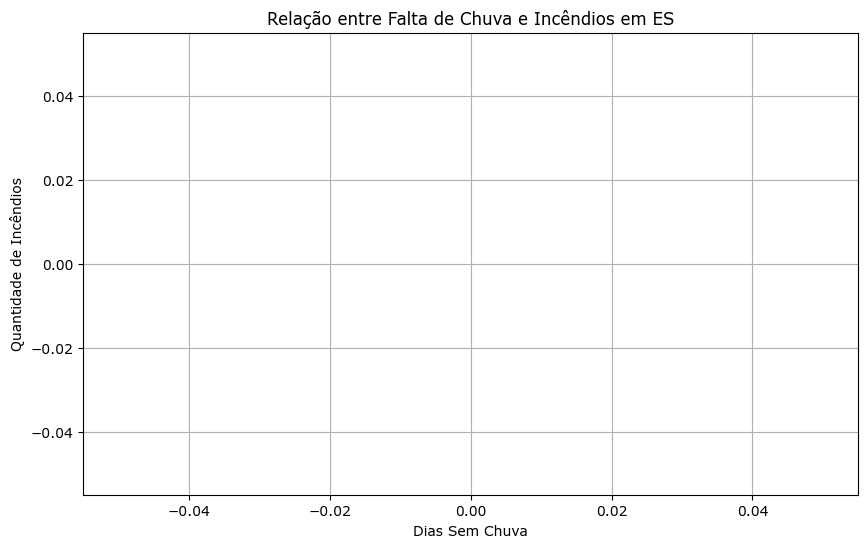

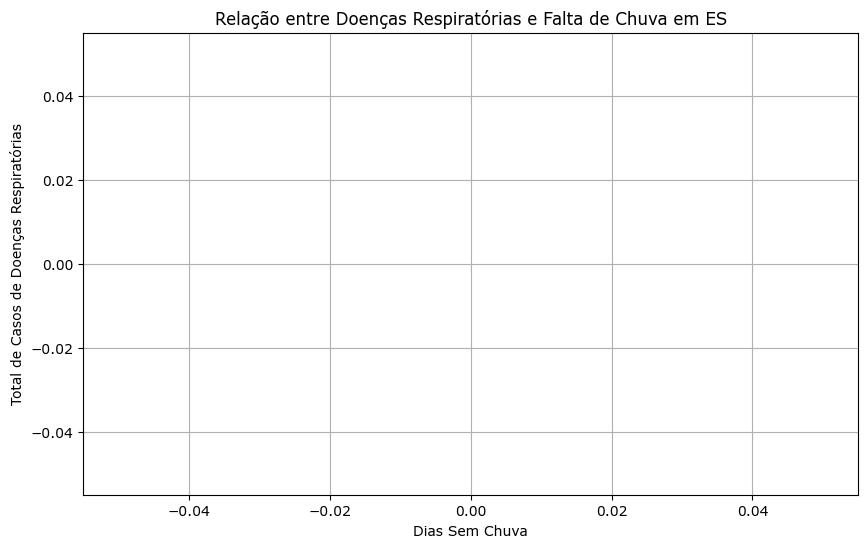

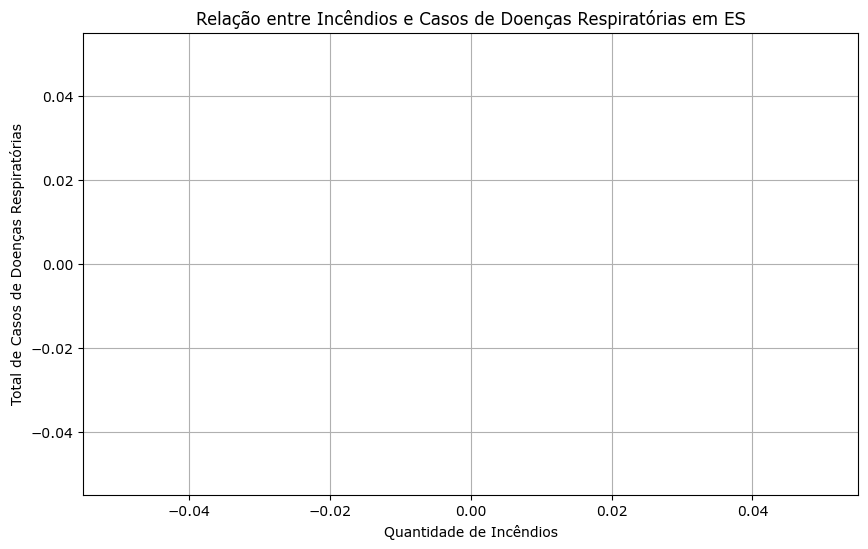

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import unidecode
import re

# Dicionário de conversão de estados para siglas
estado_para_sigla = {
    "ACRE": "AC", "ALAGOAS": "AL", "AMAPA": "AP", "AMAZONAS": "AM",
    "BAHIA": "BA", "CEARA": "CE", "DISTRITO FEDERAL": "DF", "ESPIRITO SANTO": "ES",
    "GOIAS": "GO", "MARANHAO": "MA", "MATO GROSSO": "MT", "MATO GROSSO DO SUL": "MS",
    "MINAS GERAIS": "MG", "PARA": "PA", "PARAIBA": "PB", "PARANA": "PR",
    "PERNAMBUCO": "PE", "PIAUI": "PI", "RIO DE JANEIRO": "RJ", "RIO GRANDE DO NORTE": "RN",
    "RIO GRANDE DO SUL": "RS", "RONDONIA": "RO", "RORAIMA": "RR", "SANTA CATARINA": "SC",
    "SAO PAULO": "SP", "SERGIPE": "SE", "TOCANTINS": "TO"
}

# Função para normalizar textos (remover acentos e caracteres especiais)
def normalize_text(text):
    text = unidecode.unidecode(text.strip().upper())
    return re.sub(r'[^A-Z\s]', '', text)

# Carregar os dados de queimadas e de saúde
queimadas = pd.read_excel("DadosQueimadas.xlsx")
saude = pd.read_excel("DadosSaude.xlsx")

# Normalizar e corrigir municípios e estados nos dados de queimadas
queimadas['Municipio'] = queimadas['Municipio'].apply(normalize_text)
queimadas['Estado'] = queimadas['Estado'].apply(normalize_text)
queimadas['Estado'] = queimadas['Estado'].map(estado_para_sigla)
queimadas = queimadas.dropna(subset=['Estado', 'Municipio'])

# Normalizar colunas de município e estado no dataset de saúde
saude['ID_MUNICIP'] = saude['ID_MUNICIP'].apply(normalize_text)
saude['SG_UF_NOT'] = saude['SG_UF_NOT'].apply(normalize_text)

# Criar uma coluna de total de sintomas respiratórios no DataFrame de saúde
saude['Total_Casos_Doencas_Respiratorias'] = saude[['TOSSE', 'DISPNEIA', 'DESC_RESP', 'ASMA', 'PNEUMOPATI']].apply(
    lambda x: (x == 1).sum(), axis=1
)

# Adicionar uma coluna para contar cada ocorrência de incêndio
queimadas['Incendios_Contagem'] = 1

# Agrupar os dados de queimadas por Município e Estado, apenas somando a contagem de incêndios e média de dias sem chuva
queimadas_agrupadas = queimadas.groupby(['Municipio', 'Estado']).agg({
    'Incendios_Contagem': 'sum',  # Contagem de incêndios
    'DiaSemChuva': 'mean'          # Média de dias sem chuva
}).reset_index()

# Mesclar os dados de saúde com os dados agregados de queimadas
dados_combinados = pd.merge(saude, queimadas_agrupadas, left_on=['ID_MUNICIP', 'SG_UF_NOT'], right_on=['Municipio', 'Estado'], how='inner')

# Filtrar apenas os estados da região Sudeste
sudeste_estados = ['SP', 'RJ', 'MG', 'ES']
dados_sudeste = dados_combinados[dados_combinados['Estado'].isin(sudeste_estados)]

# Criar gráficos de dispersão separados para cada estado
for estado in sudeste_estados:
    dados_estado = dados_sudeste[dados_sudeste['Estado'] == estado]
    
    # Gráfico de Dispersão: Relação entre Falta de Chuva e Incêndios para o estado atual
    plt.figure(figsize=(10, 6))
    plt.scatter(dados_estado['DiaSemChuva'], dados_estado['Incendios_Contagem'], color='orange')
    plt.title(f'Relação entre Falta de Chuva e Incêndios em {estado}')
    plt.xlabel('Dias Sem Chuva')
    plt.ylabel('Quantidade de Incêndios')
    plt.grid()
    plt.show()

    # Gráfico de Dispersão: Relação entre Doenças Respiratórias e Falta de Chuva para o estado atual
    plt.figure(figsize=(10, 6))
    plt.scatter(dados_estado['DiaSemChuva'], dados_estado['Total_Casos_Doencas_Respiratorias'], color='red')
    plt.title(f'Relação entre Doenças Respiratórias e Falta de Chuva em {estado}')
    plt.xlabel('Dias Sem Chuva')
    plt.ylabel('Total de Casos de Doenças Respiratórias')
    plt.grid()
    plt.show()

    # Gráfico de Dispersão: Relação entre Incêndios e Casos de Doenças Respiratórias para o estado atual
    plt.figure(figsize=(10, 6))
    plt.scatter(dados_estado['Incendios_Contagem'], dados_estado['Total_Casos_Doencas_Respiratorias'], color='blue')
    plt.title(f'Relação entre Incêndios e Casos de Doenças Respiratórias em {estado}')
    plt.xlabel('Quantidade de Incêndios')
    plt.ylabel('Total de Casos de Doenças Respiratórias')
    plt.grid()
    plt.show()


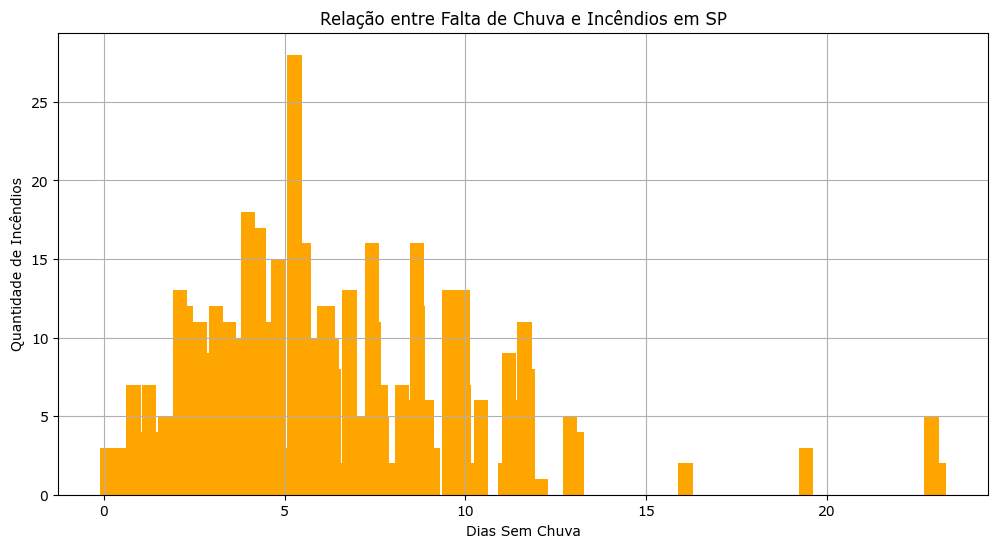

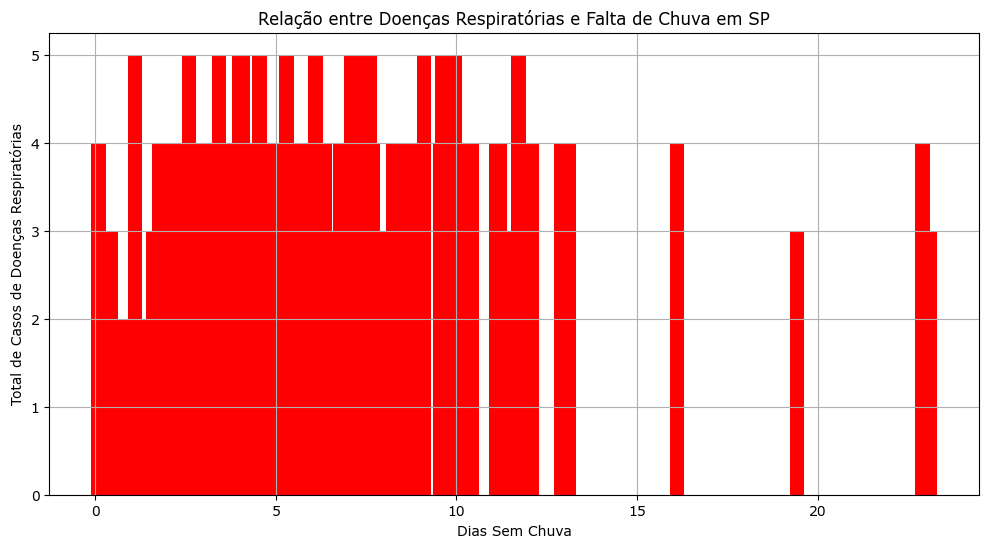

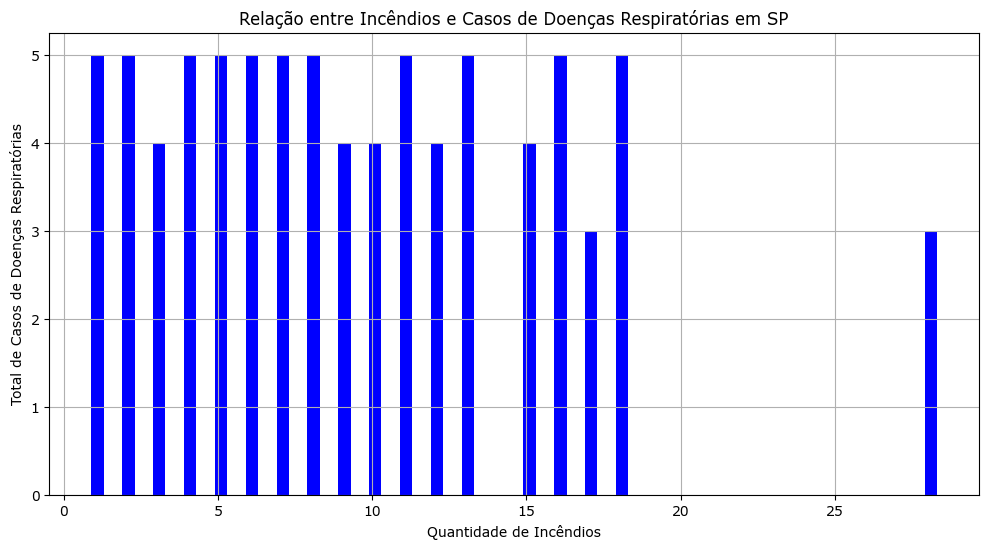

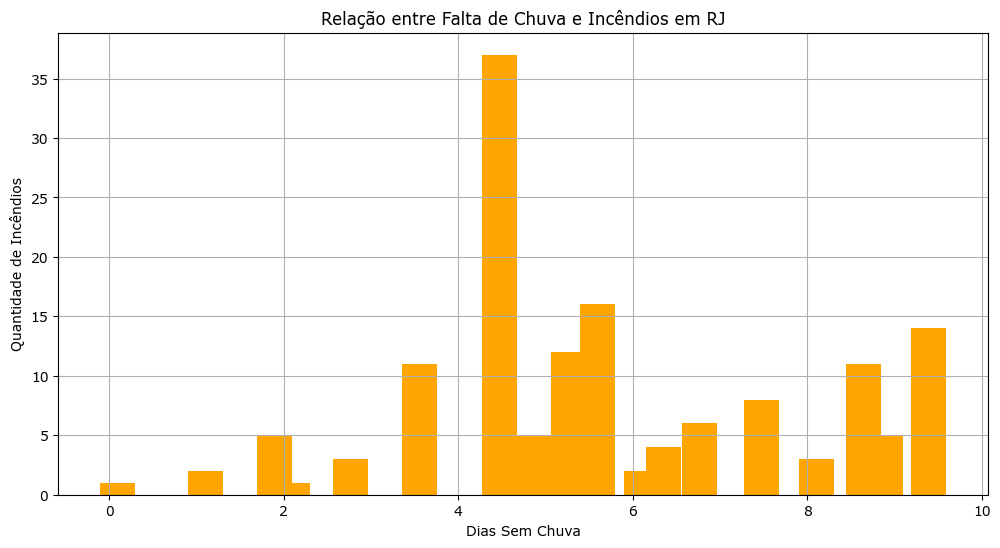

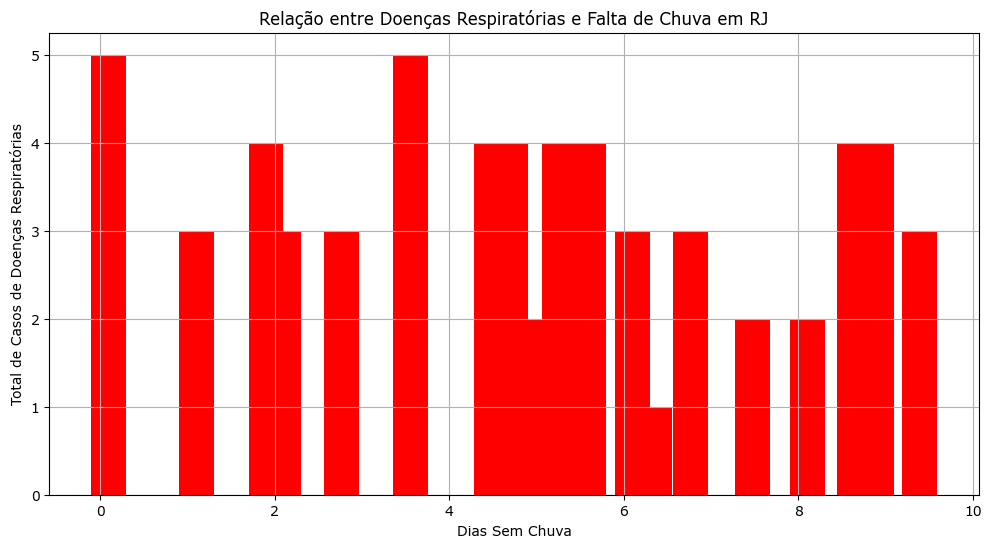

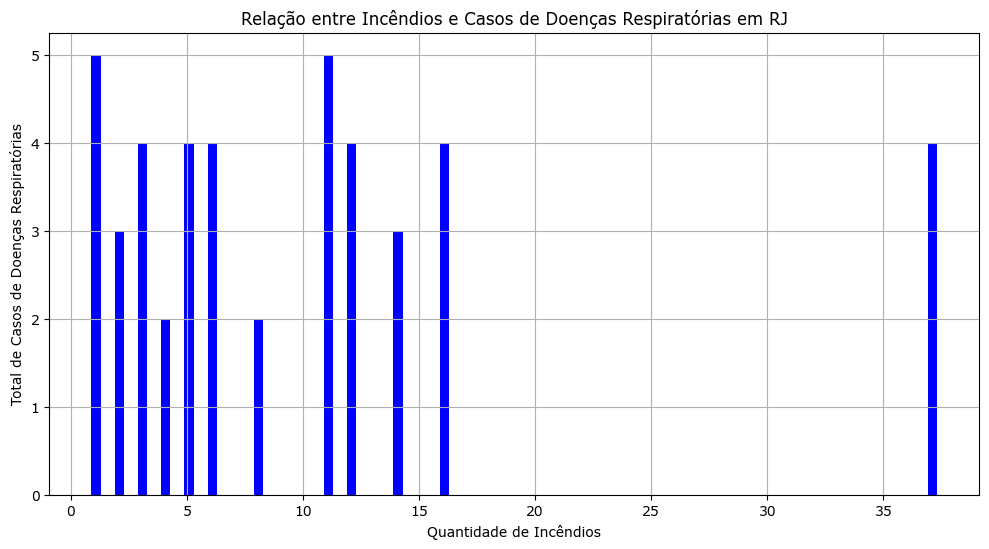

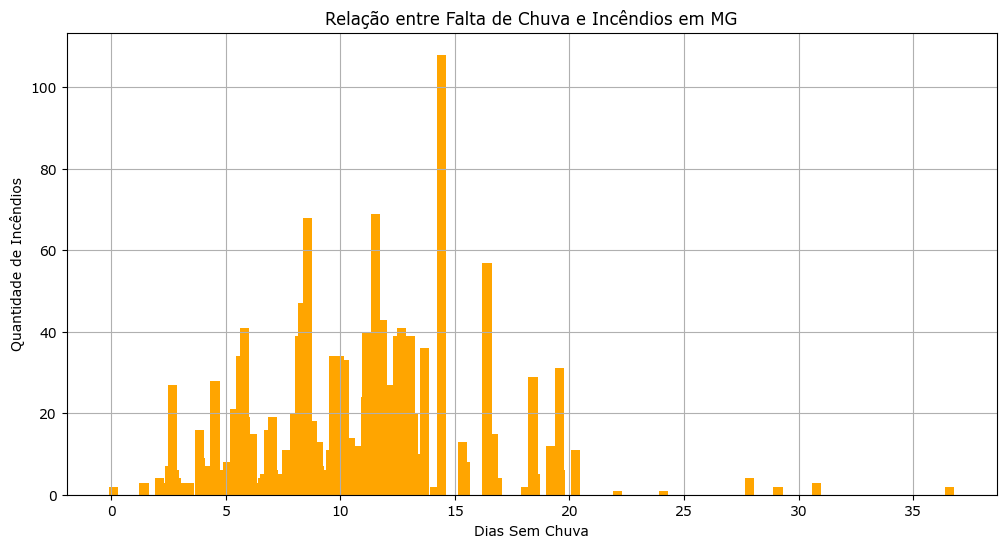

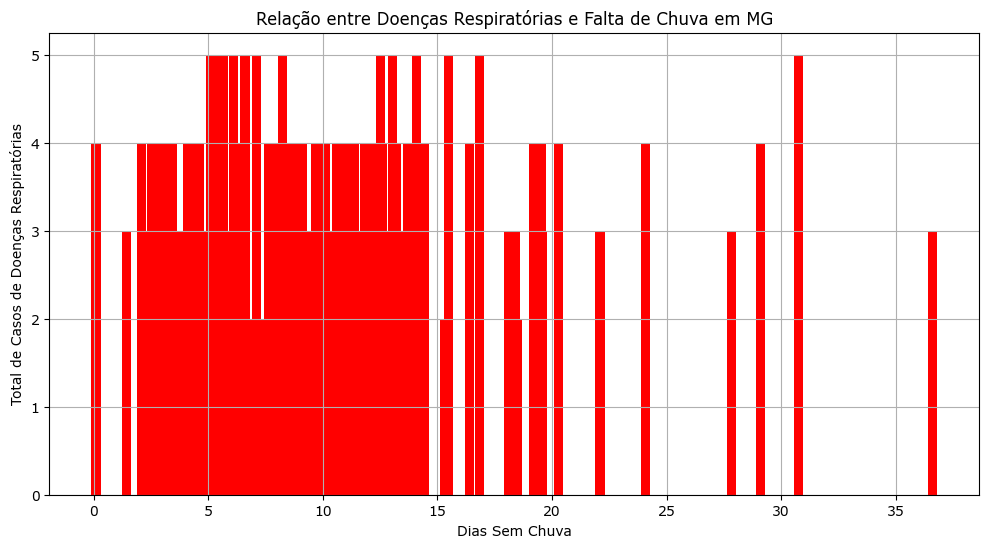

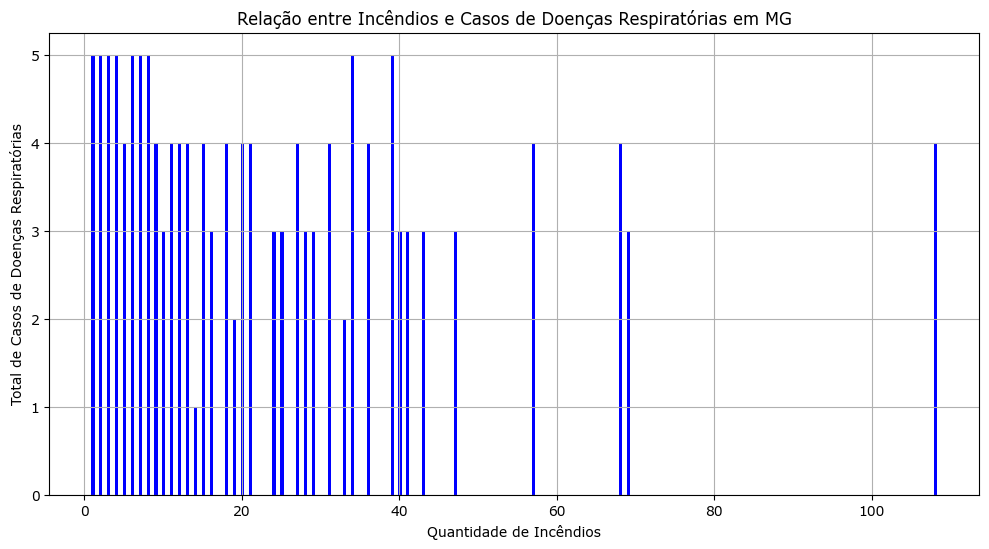

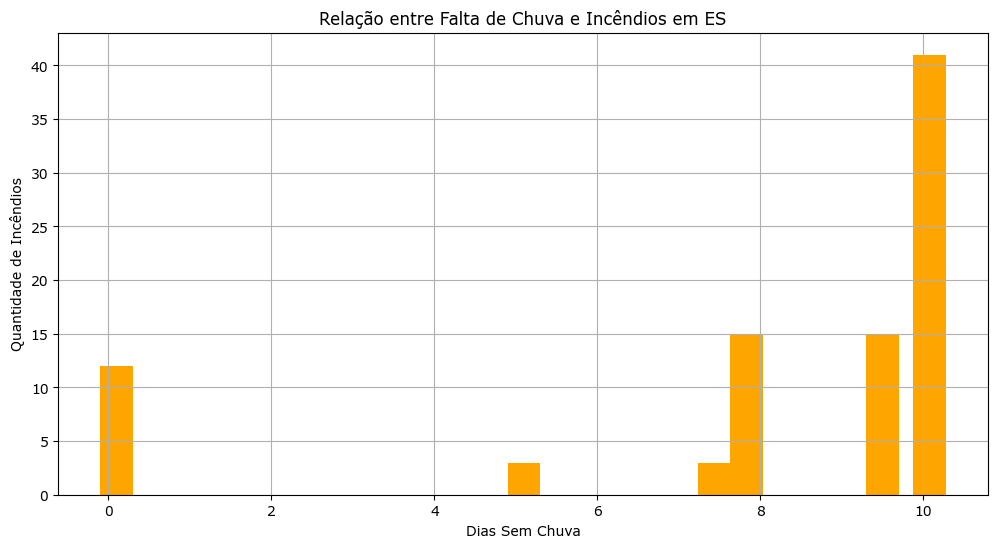

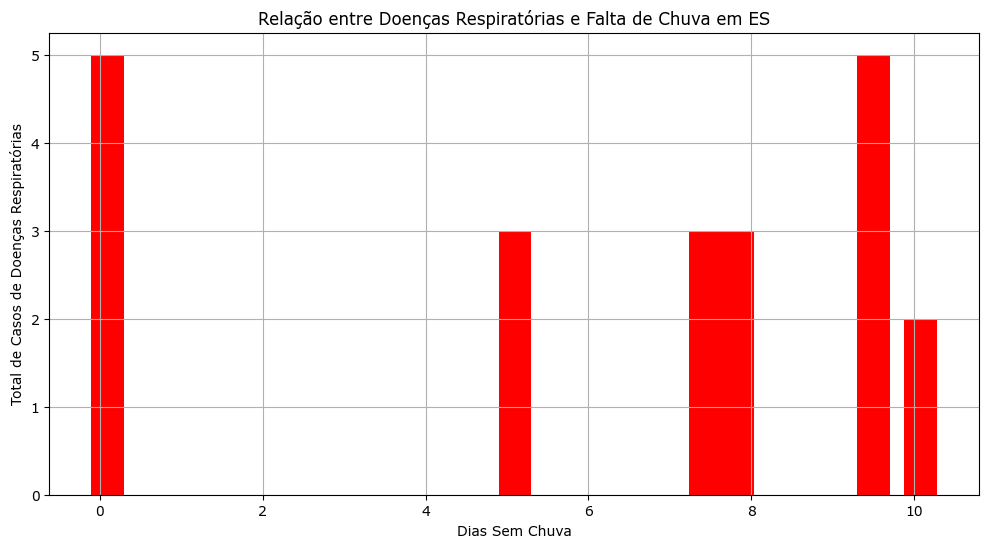

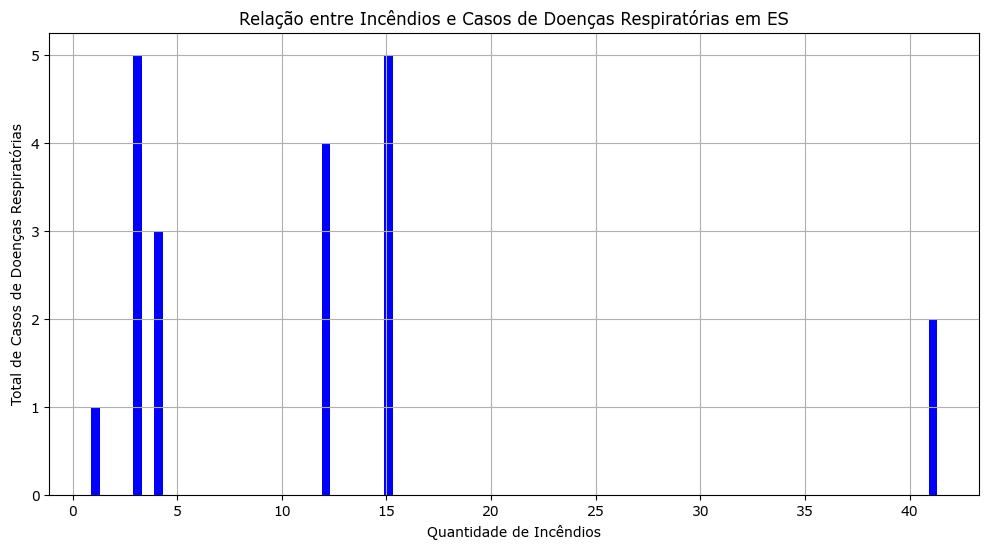

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import unidecode
import re

# Dicionário de conversão de estados para siglas
estado_para_sigla = {
    "ACRE": "AC", "ALAGOAS": "AL", "AMAPA": "AP", "AMAZONAS": "AM",
    "BAHIA": "BA", "CEARA": "CE", "DISTRITO FEDERAL": "DF", "ESPIRITO SANTO": "ES",
    "GOIAS": "GO", "MARANHAO": "MA", "MATO GROSSO": "MT", "MATO GROSSO DO SUL": "MS",
    "MINAS GERAIS": "MG", "PARA": "PA", "PARAIBA": "PB", "PARANA": "PR",
    "PERNAMBUCO": "PE", "PIAUI": "PI", "RIO DE JANEIRO": "RJ", "RIO GRANDE DO NORTE": "RN",
    "RIO GRANDE DO SUL": "RS", "RONDONIA": "RO", "RORAIMA": "RR", "SANTA CATARINA": "SC",
    "SAO PAULO": "SP", "SERGIPE": "SE", "TOCANTINS": "TO"
}

# Função para normalizar textos (remover acentos e caracteres especiais)
def normalize_text(text):
    text = unidecode.unidecode(text.strip().upper())
    return re.sub(r'[^A-Z\s]', '', text)

# Função para calcular o total de sintomas respiratórios
def calcular_total_sintomas(row):
    sintomas = ['TOSSE', 'DISPNEIA', 'DESC_RESP', 'ASMA', 'PNEUMOPATI']
    return sum(row[sintoma] == 1 for sintoma in sintomas)

# Carregar os dados de queimadas e de saúde
queimadas = pd.read_excel("DadosQueimadas.xlsx")
saude = pd.read_excel("DadosSaude.xlsx")

# Normalizar e corrigir municípios e estados nos dados de queimadas
queimadas['Municipio'] = queimadas['Municipio'].apply(normalize_text)
queimadas['Estado'] = queimadas['Estado'].apply(normalize_text)
queimadas['Estado'] = queimadas['Estado'].map(estado_para_sigla)
queimadas = queimadas.dropna(subset=['Estado', 'Municipio'])

# Normalizar colunas de município e estado no dataset de saúde
saude['ID_MUNICIP'] = saude['ID_MUNICIP'].apply(normalize_text)
saude['SG_UF_NOT'] = saude['SG_UF_NOT'].apply(normalize_text)

# Aplicar a função para calcular o total de sintomas respiratórios
saude['Total_Casos_Doencas_Respiratorias'] = saude.apply(calcular_total_sintomas, axis=1)

# Adicionar uma coluna para contar cada ocorrência de incêndio
queimadas['Incendios_Contagem'] = 1

# Agrupar os dados de queimadas por Município e Estado, apenas somando a contagem de incêndios e média de dias sem chuva
queimadas_agrupadas = queimadas.groupby(['Municipio', 'Estado']).agg({
    'Incendios_Contagem': 'sum',  # Contagem de incêndios
    'DiaSemChuva': 'mean'          # Média de dias sem chuva
}).reset_index()

# Mesclar os dados de saúde com os dados agregados de queimadas
dados_combinados = pd.merge(saude, queimadas_agrupadas, left_on=['ID_MUNICIP', 'SG_UF_NOT'], right_on=['Municipio', 'Estado'], how='inner')

# Filtrar apenas os estados da região Sudeste
sudeste_estados = ['SP', 'RJ', 'MG', 'ES']
dados_sudeste = dados_combinados[dados_combinados['Estado'].isin(sudeste_estados)]

# Ajustar a largura e o espaçamento das barras
bar_width = 0.4  # Largura da barra
spacing = 0.1    # Espaçamento entre as barras

# Criar gráficos de barras para cada estado
for estado in sudeste_estados:
    dados_estado = dados_sudeste[dados_sudeste['Estado'] == estado]

    # Gráfico de Barra: Relação entre Falta de Chuva e Incêndios para o estado atual
    plt.figure(figsize=(12, 6))
    plt.bar(dados_estado['DiaSemChuva'] + spacing, dados_estado['Incendios_Contagem'], width=bar_width, color='orange')
    plt.title(f'Relação entre Falta de Chuva e Incêndios em {estado}')
    plt.xlabel('Dias Sem Chuva')
    plt.ylabel('Quantidade de Incêndios')
    plt.grid()
    plt.show()

    # Gráfico de Barra: Relação entre Doenças Respiratórias e Falta de Chuva para o estado atual
    plt.figure(figsize=(12, 6))
    plt.bar(dados_estado['DiaSemChuva'] + spacing, dados_estado['Total_Casos_Doencas_Respiratorias'], width=bar_width, color='red')
    plt.title(f'Relação entre Doenças Respiratórias e Falta de Chuva em {estado}')
    plt.xlabel('Dias Sem Chuva')
    plt.ylabel('Total de Casos de Doenças Respiratórias')
    plt.grid()
    plt.show()

    # Gráfico de Barra: Relação entre Incêndios e Casos de Doenças Respiratórias para o estado atual
    plt.figure(figsize=(12, 6))
    plt.bar(dados_estado['Incendios_Contagem'] + spacing, dados_estado['Total_Casos_Doencas_Respiratorias'], width=bar_width, color='blue')
    plt.title(f'Relação entre Incêndios e Casos de Doenças Respiratórias em {estado}')
    plt.xlabel('Quantidade de Incêndios')
    plt.ylabel('Total de Casos de Doenças Respiratórias')
    plt.grid()
    plt.show()
